### Generating Blobs

Credit to scikit-learn.org's cluster examples tutorial. 
https://scikit-learn.org/stable/auto_examples/cluster/plot_linkage_comparison.html#sphx-glr-auto-examples-cluster-plot-linkage-comparison-py

In [2]:
import numpy as np
import plotly.graph_objects as go

import time

from sklearn import cluster, datasets
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice

In [3]:
n_samples = 1000
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=0.5, noise=0.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=0.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=511)
no_structure = np.random.rand(n_samples, 2), None

X, y = datasets.make_blobs(n_samples=n_samples, random_state=511)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)

varied = datasets.make_blobs(n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=511)

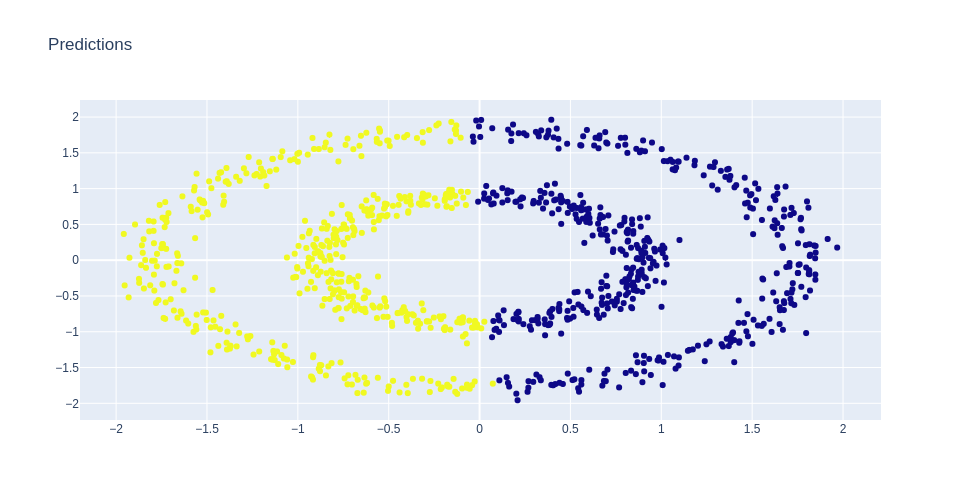

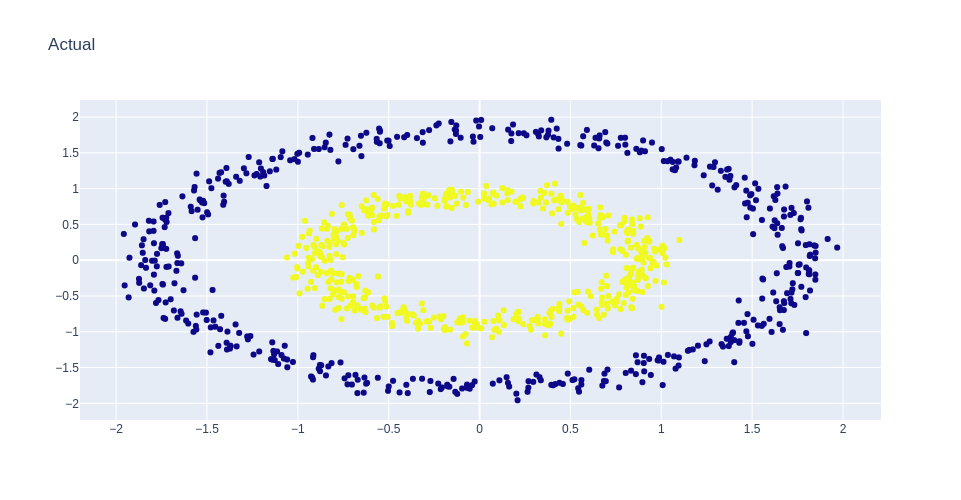

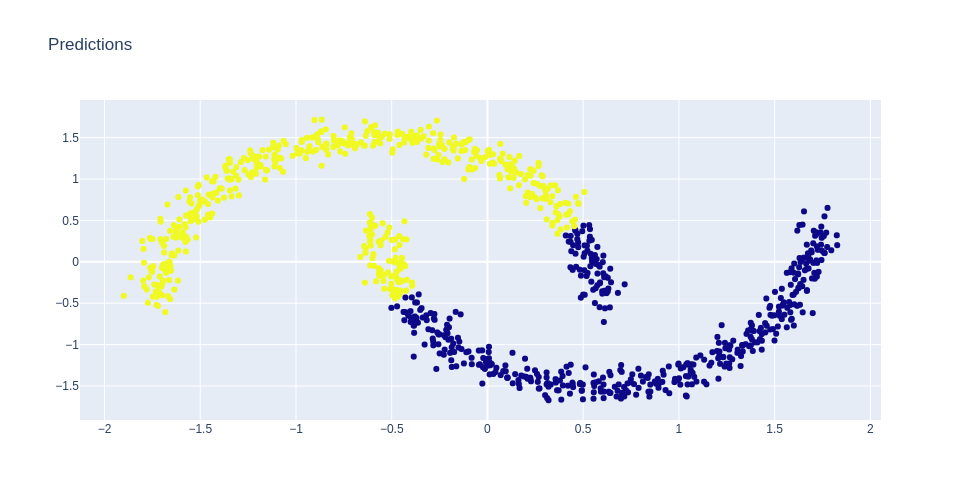

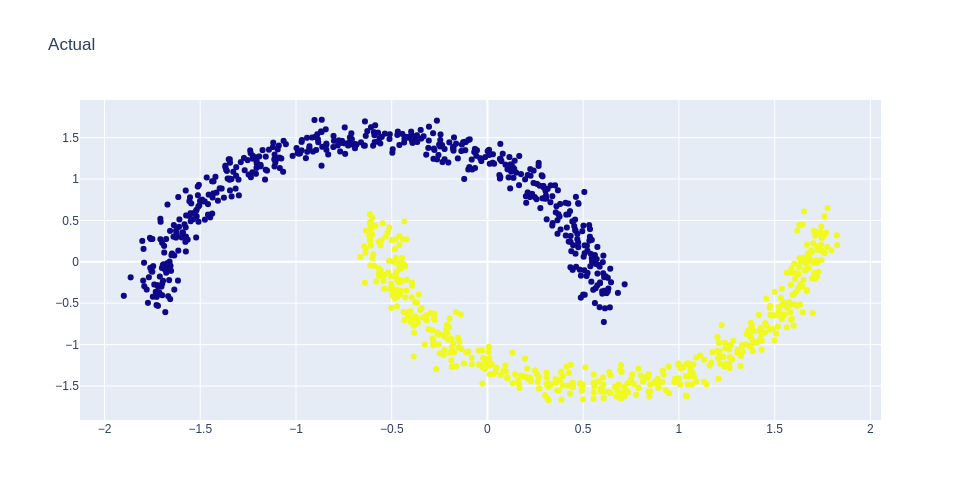

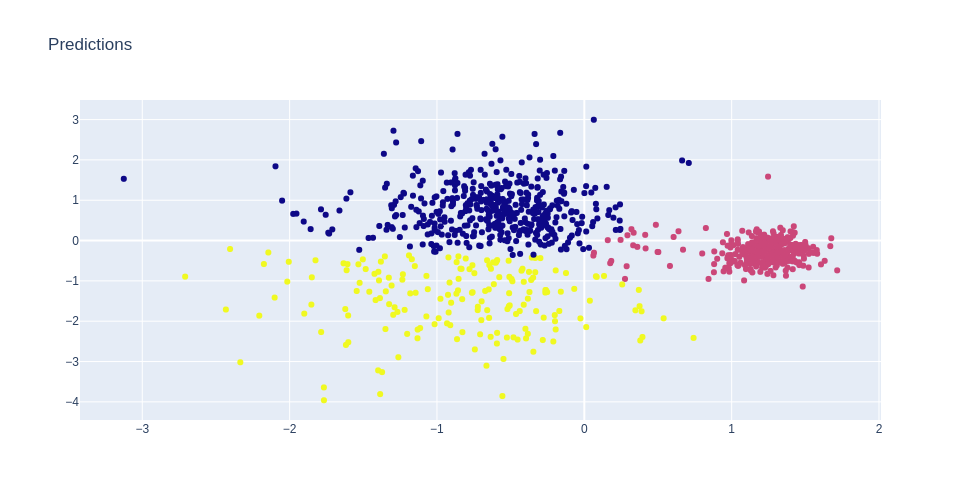

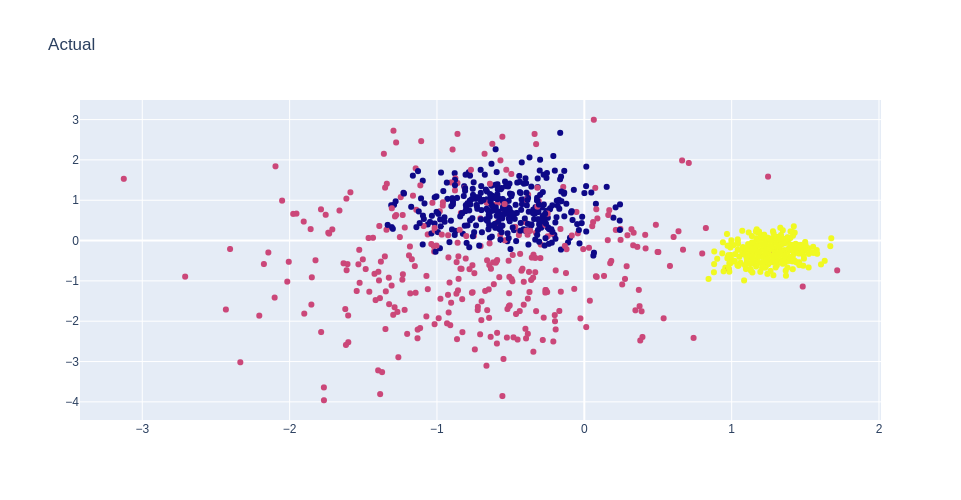

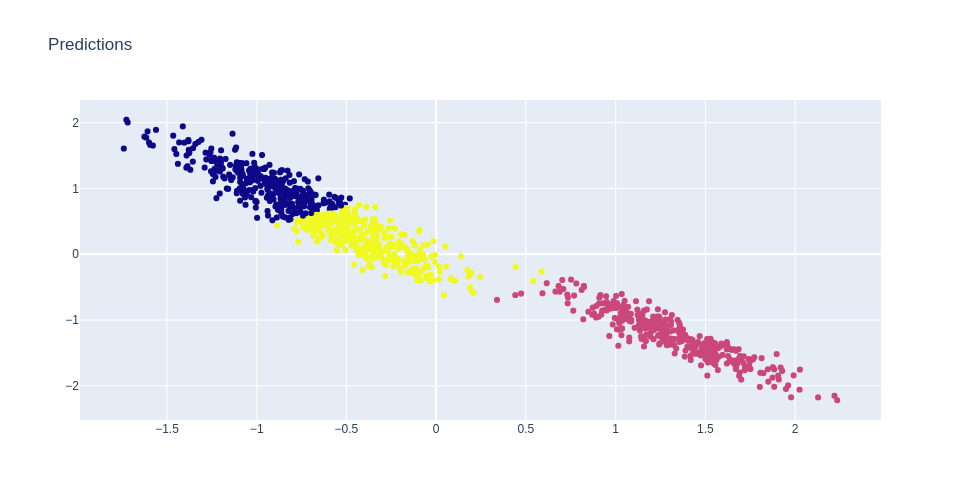

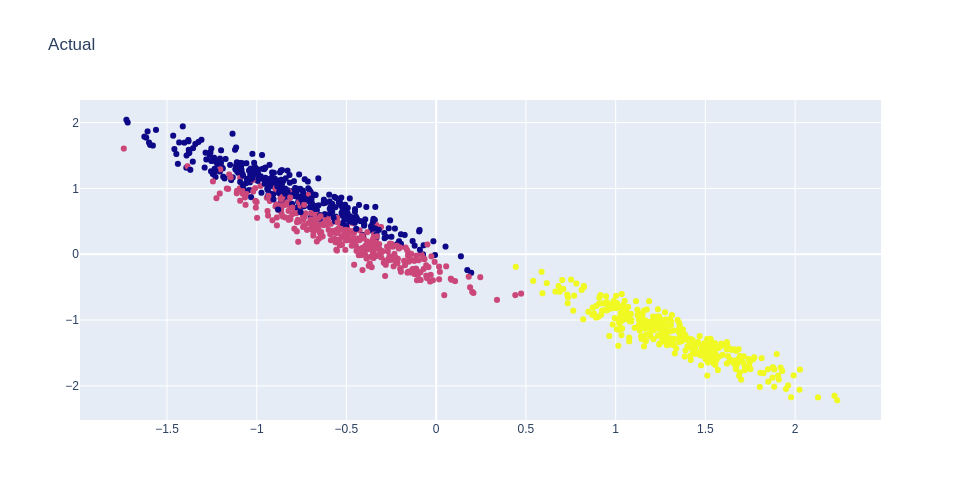

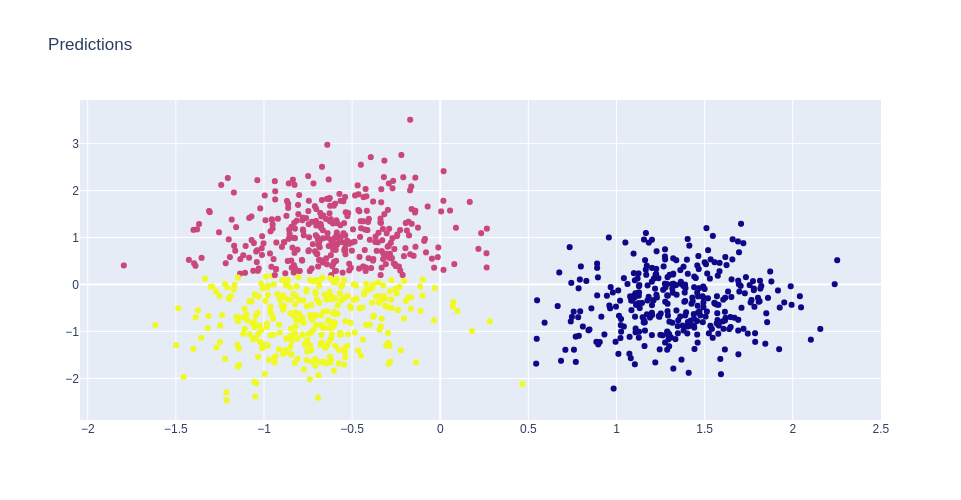

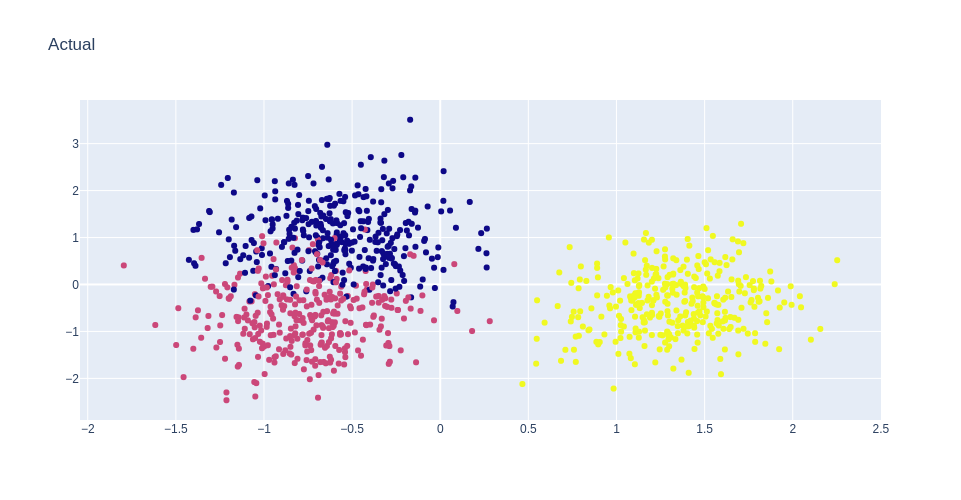

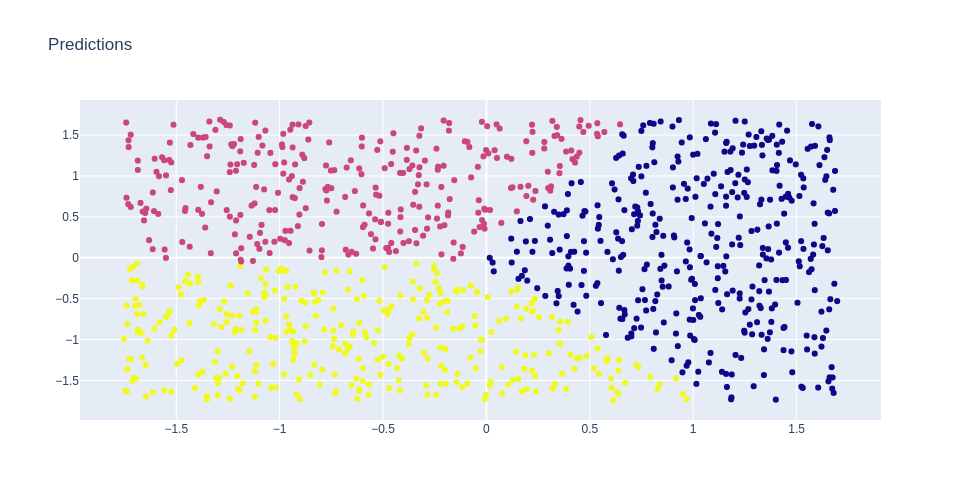

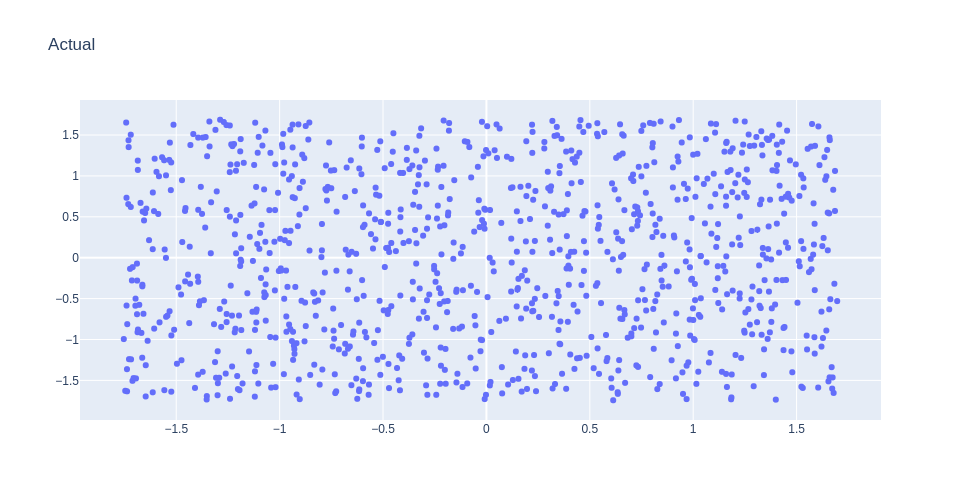

In [12]:
plot_num = 1

default_base = {
    'n_neighbors': 10,
    'n_clusters': 3,
}

datasets = [
    (noisy_circles, {'n_clusters': 2}),
    (noisy_moons, {'n_clusters': 2}),
    (varied, {'n_neighbors': 2}),
    (aniso, {'n_neighbors': 2}),
    (blobs, {}),
    (no_structure, {}),
]

for i, ((X, y), algo_params) in enumerate(datasets):
    params = default_base.copy()
    params.update(algo_params)
    
    # normalize for easier parameter selection
    X = StandardScaler().fit_transform(X)
    
    clustering = cluster.KMeans(n_clusters=params["n_clusters"])
    clustering.fit(X)
        
    fig = go.Figure(
        go.Scatter(x=X[:, 0], y=X[:, 1], mode="markers", marker={"color": clustering.labels_})
    )
    fig.update_layout(title="Predictions", width=500, height=500)
    fig.show()
    
    fig = go.Figure(
        go.Scatter(x=X[:, 0], y=X[:, 1], mode="markers", marker={"color": y})
    )
    fig.update_layout(title="Actual", width=500, height=500)
    fig.show()

### Implementation of DBSCAN

Credit to pseudocode at https://en.wikipedia.org/wiki/DBSCAN

In [96]:
from collections import defaultdict

class DBSCAN:
    
    def __init__(self, eps=0.2, minpts=3, distfunc=(lambda p1, p2: np.linalg.norm(p1-p2))):
        # TODO behavior for eps="auto"
        assert eps == "auto" or type(eps) in (int, float)
        assert type(minpts) is int
        assert callable(distfunc)
        self.__eps = eps
        self.__distfunc = distfunc
        self.__minpts = minpts
    
    def fit(self, points):
        count = 0
        self.__labels = defaultdict(lambda: None)
        for P in points:
            # the point has already been processed in the inner loop
            if self.__getLabel(P) is not None:
                continue
            neighbors = self.__rangeQuery(points, P)
            if len(neighbors) < self.__minpts:
                self.__setLabel(P, -1) # point is noise
                continue
            
            # expand the cluster
            count += 1
            self.__setLabel(P, count)
            j = 0
            S = set(tuple(Q) for Q in neighbors)
            N = list(neighbors)
            while j < len(N):
                Q = N[j]
                j += 1
                if self.__getLabel(Q) == -1:
                    self.__setLabel(Q, count)
                if self.__getLabel(Q) is not None:
                    continue
                self.__setLabel(Q, count)
                neighbors = self.__rangeQuery(points, Q)
                if len(neighbors) >= self.__minpts:
                    for R in neighbors:
                        if tuple(R) in S:
                            continue
                        S.add(tuple(R))
                        N.append(R)
            
        self.labels_ = [self.__getLabel(P) for P in points]
        self.labels_ = np.array([P if P is not None else np.nan for P in self.labels_])
            
        return self
    
    def __getLabel(self, P):
        return self.__labels[tuple(P)]
    
    def __setLabel(self, P, val):
        self.__labels[tuple(P)] = val
    
    def __rangeQuery(self, points, P):
        neighbors = []
        for Q in points:
            if self.__distfunc(P, Q) <= self.__eps:
                neighbors.append(Q)
        return neighbors

In [ ]:
X, y = noisy_circles

X = StandardScaler().fit_transform(X)

c = DBSCAN(eps=0.2)
c.fit(X)

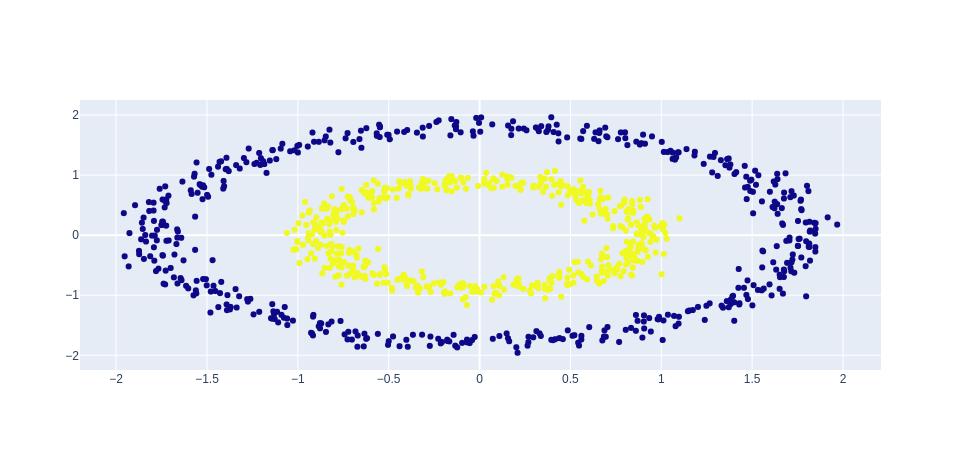

In [93]:
fig = go.Figure(
    go.Scatter(x=X[:, 0], y=X[:, 1], mode="markers", marker={"color": c.labels_})
)

fig.show()

In [62]:
X

array([[-0.56528856,  1.65364497],
       [-0.82111697,  1.5413413 ],
       [ 0.86043418, -1.32889342],
       ...,
       [-0.68805925,  0.4057569 ],
       [ 0.80426598, -1.57600017],
       [-0.09190258, -0.80380989]])